In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('gurgaon_properties_post_feature_selection_v2.csv')

In [3]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,study room,servant room,store room,furnishing_type,floor_category
0,house,sector 109,8.75,5.0,5.0,3+,New Property,3600.00,1.0,1.0,1.0,2.0,Medium floor
1,house,sector 48,6.40,4.0,4.0,3,Moderately Old,2700.00,0.0,1.0,1.0,2.0,Medium floor
2,flats,sector 49,2.90,4.0,4.0,3+,Moderately Old,2383.00,0.0,1.0,0.0,0.0,Medium floor
3,flats,manesar,0.90,3.0,3.0,3+,Moderately Old,2089.00,0.0,1.0,0.0,0.0,Medium floor
4,flats,sector 112,3.40,3.0,3.0,2,Relatively New,2225.56,0.0,0.0,0.0,2.0,High floor


In [4]:
df.columns

Index(['property_type', 'sector', 'price', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'study room', 'servant room',
       'store room', 'furnishing_type', 'floor_category'],
      dtype='object')

In [83]:
df['furnishing_type'].value_counts()

furnishing_type
0.0    2371
2.0     994
1.0     185
Name: count, dtype: int64

In [84]:
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished
df['furnishing_type'] = df['furnishing_type'].replace({0.0:'unfurnished',1.0:'semifurnished',2.0:'furnished'})

In [85]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,study room,servant room,store room,furnishing_type,floor_category
0,house,sector 109,8.75,5.0,5.0,3+,New Property,3600.00,1.0,1.0,1.0,furnished,Medium floor
1,house,sector 48,6.40,4.0,4.0,3,Moderately Old,2700.00,0.0,1.0,1.0,furnished,Medium floor
2,flats,sector 49,2.90,4.0,4.0,3+,Moderately Old,2383.00,0.0,1.0,0.0,unfurnished,Medium floor
3,flats,manesar,0.90,3.0,3.0,3+,Moderately Old,2089.00,0.0,1.0,0.0,unfurnished,Medium floor
4,flats,sector 112,3.40,3.0,3.0,2,Relatively New,2225.56,0.0,0.0,0.0,furnished,High floor


In [86]:
X = df.drop(columns=['price'])
y = df['price']

In [87]:
# Applying the log1p transformation to the target variable
y_transformed = np.log1p(y)

# Ordinal Encoding

In [88]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'floor_category']

In [89]:
# Creating a column transformer for preprocessing
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'study room', 'servant room', 'store room']),
#         ('cat', OrdinalEncoder(), columns_to_encode)
#     ], 
#     remainder='passthrough'
# )


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), columns_to_encode)
    ])

In [90]:

# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [91]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [92]:
scores.mean(),scores.std()

(0.842899072800518, 0.03364002838939808)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [94]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'floor_category'])])),
                ('regressor', LinearRegression())])

In [95]:
y_pred = pipeline.predict(X_test)

In [96]:
y_pred = np.expm1(y_pred)

In [97]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.6544662382580271

In [98]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output

In [99]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In [100]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [101]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [102]:
model_output

[['linear_reg', 0.842899072800518, 0.6544662382580271],
 ['svr', 0.875169631523859, 0.572565592417696],
 ['ridge', 0.8435664285489265, 0.6537227733897037],
 ['LASSO', -0.0032279367138987602, 1.4256772766732329],
 ['decision tree', 0.7682272595205818, 0.7584214345761706],
 ['random forest', 0.8651990591314759, 0.565437759984549],
 ['extra trees', 0.8742652359641319, 0.5532858044705478],
 ['gradient boosting', 0.8515792506647379, 0.6328881586032399],
 ['adaboost', 0.693460197158882, 0.9036283864228323],
 ['mlp', 0.8756168503567482, 0.5369260185093637],
 ['xgboost', 0.8812886501125659, 0.5459740125293463]]

In [103]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [104]:
model_df.sort_values(['mae'])

,name,r2,mae
9,mlp,0.875617,0.536926
10,xgboost,0.881289,0.545974
6,extra trees,0.874265,0.553286
5,random forest,0.865199,0.565438
1,svr,0.875170,0.572566
7,gradient boosting,0.851579,0.632888
2,ridge,0.843566,0.653723
0,linear_reg,0.842899,0.654466
4,decision tree,0.768227,0.758421
8,adaboost,0.693460,0.903628


# One Hot Encoding

In [105]:
columns_to_encode = ['property_type', 'balcony','floor_category', 'furnishing_type']

In [106]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(handle_unknown='ignore'),['sector','agePossession','furnishing_type'])
        # ('cat1',OneHotEncoder(drop='first'),['sector','agePossession','furnishing_type'])
    ], 
    remainder='passthrough'
)

In [107]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [108]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [109]:
scores.mean()

0.8417734330848055

In [110]:
scores.std()

0.03497611855086834

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [112]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'balcony',
                                                   'floor_category',
                                                   'furnishing_type']),
                                                 ('cat1',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sector', 'agePossession',
                                                   'furnishing_type'])])),
                ('regressor', LinearRegression())])

In [113]:
y_pred = pipeline.predict(X_test)

In [114]:
y_pred = np.expm1(y_pred)

In [115]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.6565480484522284

In [116]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output
    

In [117]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [118]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [119]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [120]:
model_df.sort_values(['mae'])

,name,r2,mae
10,xgboost,0.882372,0.537767
6,extra trees,0.873022,0.543393
5,random forest,0.862547,0.560210
1,svr,0.871073,0.590056
9,mlp,0.865074,0.604535
7,gradient boosting,0.850882,0.630850
0,linear_reg,0.841773,0.656548
2,ridge,0.842461,0.656750
4,decision tree,0.768252,0.768911
8,adaboost,0.697482,0.919757


# Target Encoder

In [121]:
import category_encoders as ce

# Columns to encode
columns_to_encode = ['property_type', 'balcony', 'furnishing_type', 'floor_category']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'study room', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1', OneHotEncoder(drop='first', sparse_output=False), ['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ], 
    remainder='passthrough'
)

In [122]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [123]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [124]:
scores.mean(),scores.std()

(0.8128344086820409, 0.03322209110406818)

In [125]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output
    

In [126]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [127]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [128]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [129]:
model_df.sort_values(['mae'])

,name,r2,mae
5,random forest,0.885457,0.524420
10,xgboost,0.882894,0.526107
6,extra trees,0.881571,0.527369
7,gradient boosting,0.872488,0.568776
1,svr,0.844624,0.658498
9,mlp,0.838530,0.676432
4,decision tree,0.787308,0.729870
2,ridge,0.812865,0.731533
0,linear_reg,0.812834,0.731756
8,adaboost,0.795432,0.747988


# Hyperparameter Tuning

In [150]:
param_grid_rf = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__bootstrap': [True, False]
}


In [151]:
param_grid_gb = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.8, 1.0],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}


In [152]:
param_grid_xgb = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0],
    'regressor__gamma': [0, 0.1, 0.3],
}


In [153]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())  
])


param_grid = param_grid_rf  


grid_search = GridSearchCV(estimator=model_pipeline, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='neg_mean_absolute_error',  # Use MAE as the metric
                           n_jobs=-1, 
                           verbose=2)


grid_search.fit(X_train, y_train)


print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (MAE): ", -grid_search.best_score_)


best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test set score: {test_score}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found:  {'regressor__bootstrap': True, 'regressor__max_depth': 30, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best cross-validation score (MAE):  0.12344140523958817
Test set score: 0.8549882653426485


In [154]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


In [155]:
# Retrieve the best model from grid search
best_model = grid_search.best_estimator_

In [156]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

In [157]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [158]:
print("Test Set Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Test Set Evaluation Metrics:
Mean Absolute Error (MAE): 0.1234
Mean Squared Error (MSE): 0.0401
Root Mean Squared Error (RMSE): 0.2002
R² Score: 0.8550


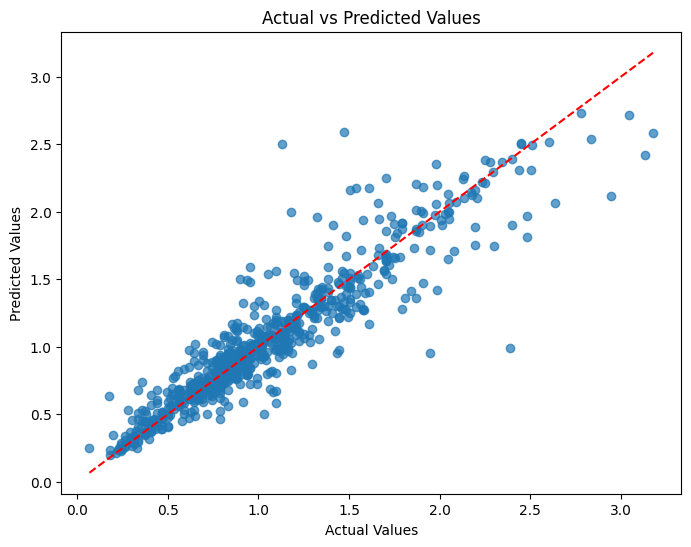

In [159]:
# Plot Predicted vs Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

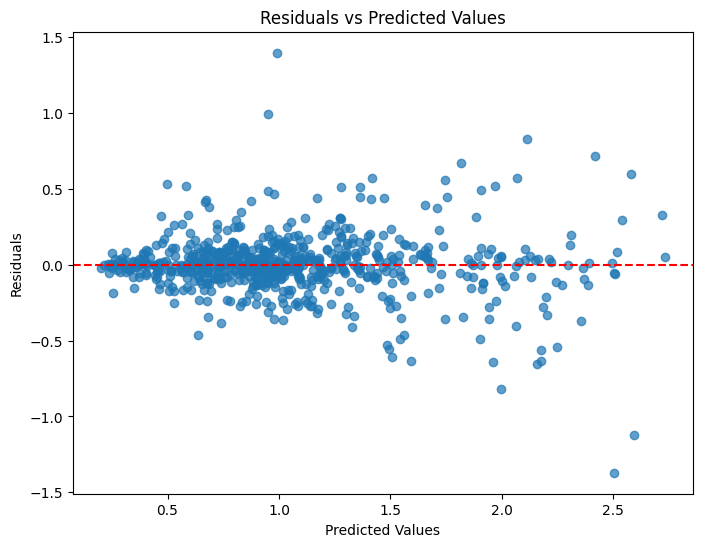

In [161]:
# Calculate residuals
residuals = y_test - y_pred

# Plot Residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.axhline(0, color='r', linestyle='--')
plt.show()

In [162]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'balcony',
                                                   'furnishing_type',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['agePossession']),
                                                 ('target_enc', TargetEncoder(),
                                                  ['sector'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=30, n_estimators=200))])

In [207]:
import joblib

# Preprocessing and Pipeline setup
columns_to_encode = ['property_type', 'balcony', 'furnishing_type', 'floor_category']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'study room', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1', OneHotEncoder(drop='first', sparse_output=False), ['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ], 
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500))
])

# Fit the pipeline to the data
pipeline.fit(X, y_transformed)

# Save the pipeline using joblib
model_filename = 'pipeline_model.pkl'
joblib.dump(pipeline, model_filename)

# Optionally, save the feature data (if needed for later reference)
data_filename = 'X_data.pkl'
joblib.dump(X, data_filename)

print(f"Pipeline and data saved to {model_filename} and {data_filename}")




# columns_to_encode = ['property_type', 'balcony', 'furnishing_type', 'floor_category']
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'study room', 'servant room', 'store room']),
#         ('cat', OrdinalEncoder(), columns_to_encode),
#         ('cat1', OneHotEncoder(drop='first', sparse_output=False), ['agePossession']),
#         ('target_enc', ce.TargetEncoder(), ['sector'])
#     ], 
#     remainder='passthrough'
# )


# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('regressor', RandomForestRegressor(n_estimators=500))
# ])

Pipeline and data saved to pipeline_model.pkl and X_data.pkl


In [208]:
# pipeline.fit(X,y_transformed)

In [209]:
# import pickle

# with open('pipeline.pkl', 'wb') as file:
#     pickle.dump(pipeline, file)

In [210]:
# with open('df.pkl', 'wb') as file:
#     pickle.dump(X, file)

In [211]:
X

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,study room,servant room,store room,furnishing_type,floor_category
0,house,sector 109,5.0,5.0,3+,New Property,3600.00,1.0,1.0,1.0,furnished,Medium floor
1,house,sector 48,4.0,4.0,3,Moderately Old,2700.00,0.0,1.0,1.0,furnished,Medium floor
2,flats,sector 49,4.0,4.0,3+,Moderately Old,2383.00,0.0,1.0,0.0,unfurnished,Medium floor
3,flats,manesar,3.0,3.0,3+,Moderately Old,2089.00,0.0,1.0,0.0,unfurnished,Medium floor
4,flats,sector 112,3.0,3.0,2,Relatively New,2225.56,0.0,0.0,0.0,furnished,High floor
...,...,...,...,...,...,...,...,...,...,...,...,...
3545,flats,sector 56,4.0,4.0,2,Under Construction,2300.00,0.0,0.0,0.0,unfurnished,Medium floor
3546,house,sector 92,4.0,4.0,3+,Relatively New,5000.00,1.0,0.0,0.0,unfurnished,Medium floor
3547,flats,sector 78,3.0,3.0,3+,Old Property,2176.00,0.0,1.0,0.0,unfurnished,Medium floor
3548,flats,sector 33,2.0,2.0,3,Relatively New,1266.00,0.0,0.0,0.0,unfurnished,Medium floor


# Trying out the predictions

In [212]:
X.columns

Index(['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'study room', 'servant room',
       'store room', 'furnishing_type', 'floor_category'],
      dtype='object')

In [213]:
X.iloc[0].values

array(['house', 'sector 109', 5.0, 5.0, '3+', 'New Property', 3600.0, 1.0,
       1.0, 1.0, 'furnished', 'Medium floor'], dtype=object)

In [214]:
data = [['house', 'sector 102', 4, 3, '3+', 'New Property', 2750, 0, 0, 0, 'unfurnished', 'Low floor']]
columns = ['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'study room', 'servant room',
       'store room', 'furnishing_type', 'floor_category']

# Convert to DataFrame
one_df = pd.DataFrame(data, columns=columns)

one_df

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,study room,servant room,store room,furnishing_type,floor_category
0,house,sector 102,4,3,3+,New Property,2750,0,0,0,unfurnished,Low floor


In [216]:
np.expm1(pipeline.predict(one_df))

array([2.62184826])

In [217]:
X.dtypes

property_type       object
sector              object
bedRoom            float64
bathroom           float64
balcony             object
agePossession       object
built_up_area      float64
study room         float64
servant room       float64
store room         float64
furnishing_type     object
floor_category      object
dtype: object